# Extração de Dados - Segurança Pública SP

Este notebook realiza a primeira etapa do pipeline ETL (Extract, Transform, Load), responsável pela **extração** de dados do arquivo Excel da SSP-SP (Secretaria de Segurança Pública de São Paulo).

## Contexto

A Secretaria de Segurança Pública do Estado de São Paulo disponibiliza dados mensais sobre ocorrências criminais através de arquivos Excel. Estes dados são essenciais para análises de segurança pública, permitindo identificar padrões de criminalidade, regiões de maior incidência e tendências temporais.

## Objetivos da Extração

Este notebook tem como finalidade:
- Carregar dados do arquivo Excel `SPDadosCriminais_2025.xlsx` localizado em `data/raw/`
- Analisar a estrutura das abas (sheets) disponíveis no arquivo
- Consolidar dados de múltiplas abas em um único dataset
- Validar a integridade dos dados extraídos
- Registrar metadados do processo de extração para rastreabilidade

## Estrutura do Arquivo Excel

O arquivo fonte contém três abas principais:
1. **Dicionário de Dados**: documentação das colunas e seus significados
2. **JAN-JUN**: registros de ocorrências criminais de janeiro a junho de 2025
3. **JUN-SET**: registros de ocorrências criminais de julho a setembro de 2025

## Resultado Esperado

Ao final deste notebook, teremos um arquivo consolidado em formato Parquet salvo em `data/interim/dados_brutos_consolidados.parquet`, contendo todos os registros das abas de dados, pronto para a próxima etapa de transformação.

---

## 1. Importar Bibliotecas e Configurações

Nesta seção, importamos todas as bibliotecas necessárias para o processo de extração de dados. As principais bibliotecas utilizadas são:

- **pandas**: para manipulação e análise de dados tabulares
- **numpy**: para operações numéricas e manipulação de arrays
- **pathlib**: para gerenciamento de caminhos de arquivos de forma multiplataforma
- **logging**: para registro de eventos e diagnóstico do processo
- **extract**: módulo customizado localizado em `src/` contendo funções específicas de extração

Também configuramos o sistema de logging para acompanhar o progresso e identificar possíveis problemas durante a execução.

In [16]:
# Importar bibliotecas necessárias
import sys
import os
import pandas as pd
import numpy as np
import logging
from pathlib import Path
from datetime import datetime

# Adicionar o diretório src ao path para importar os módulos
project_root = Path().resolve().parent
sys.path.append(str(project_root / 'src'))

from extract import extract_local_file # Importar funções de extração

# Configurar logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

print("Bibliotecas importadas com sucesso")
print(f"Diretório do projeto: {project_root}")

Bibliotecas importadas com sucesso
Diretório do projeto: C:\Users\jodes\OneDrive\Documentos\Projetos-GitHub\public-security-data


## 2. Configurar Diretórios e Parâmetros

Definimos a estrutura de diretórios do projeto seguindo boas práticas de organização de dados:

- **data/raw/**: armazena dados brutos, não modificados
- **data/interim/**: armazena dados intermediários durante o processo ETL
- **data/processed/**: armazenará dados finais, transformados e limpos

Esta célula também verifica a existência do arquivo Excel fonte e exibe informações básicas como nome e tamanho, permitindo validar que os recursos necessários estão disponíveis antes de prosseguir com a extração.

In [17]:
# Definir diretórios do projeto
PROJECT_ROOT = Path().resolve().parent
DATA_RAW_DIR = PROJECT_ROOT / 'data' / 'raw'
DATA_INTERIM_DIR = PROJECT_ROOT / 'data' / 'interim'

# Verificar diretórios
print(f"Diretório de dados brutos: {DATA_RAW_DIR}")
print(f"Diretório de dados intermediários: {DATA_INTERIM_DIR}")

# Arquivo Excel principal
EXCEL_FILE = DATA_RAW_DIR / 'SPDadosCriminais_2025.xlsx'

# Verificar se o arquivo existe
if EXCEL_FILE.exists():
    size_mb = EXCEL_FILE.stat().st_size / (1024**2)
    print(f"\nArquivo encontrado: {EXCEL_FILE.name}")
    print(f"Tamanho: {size_mb:.2f} MB")
else:
    print(f"\nArquivo não encontrado: {EXCEL_FILE}")

Diretório de dados brutos: C:\Users\jodes\OneDrive\Documentos\Projetos-GitHub\public-security-data\data\raw
Diretório de dados intermediários: C:\Users\jodes\OneDrive\Documentos\Projetos-GitHub\public-security-data\data\interim

Arquivo encontrado: SPDadosCriminais_2025.xlsx
Tamanho: 136.14 MB


## 3. Análise da Estrutura do Arquivo Excel

Antes de extrair os dados, é fundamental compreender a estrutura do arquivo Excel. Esta análise exploratória inicial nos permite:

- Identificar todas as abas (sheets) disponíveis no arquivo
- Compreender o esquema de dados de cada aba
- Verificar quantidades de registros e colunas
- Detectar possíveis inconsistências estruturais

### Estrutura Identificada

No arquivo `SPDadosCriminais_2025.xlsx`, identificamos três abas principais:

1. **Dicionário de Dados**: contém a documentação completa de cada coluna, incluindo tipo de dado, descrição e possíveis valores. Esta aba serve como metadado essencial para interpretação correta dos dados.

2. **JAN-JUN**: registros de ocorrências criminais do primeiro semestre de 2025 (janeiro a junho). Contém informações detalhadas sobre cada boletim de ocorrência, incluindo localização, tipo de crime, data e hora.

3. **JUN-SET**: registros de ocorrências criminais do segundo trimestre de 2025 (julho a setembro). Mantém a mesma estrutura da aba anterior, permitindo consolidação consistente.

Para este projeto, focamos nas duas últimas abas, que contêm os dados operacionais de criminalidade.

In [18]:
# Analisar estrutura do arquivo Excel
print()
print("ANÁLISE DA ESTRUTURA DO ARQUIVO EXCEL")
print()

# Carregar arquivo Excel para análise
xl = pd.ExcelFile(EXCEL_FILE)

print(f"\nAbas disponíveis: {len(xl.sheet_names)}")
for i, sheet in enumerate(xl.sheet_names, 1):
    print(f"   {i}. {sheet}")

# Analisar cada aba
print(f"\n")
print("DETALHES DE CADA ABA")
print(f"\n")

sheets_info = {}

for sheet_name in xl.sheet_names:
    print(f"Aba: {sheet_name}")
    print(f"   {'-'*60}")
    
    # Ler amostra da aba
    df_sample = pd.read_excel(EXCEL_FILE, sheet_name=sheet_name, nrows=5)
    
    sheets_info[sheet_name] = {
        'shape': df_sample.shape,
        'columns': list(df_sample.columns),
        'dtypes': df_sample.dtypes.to_dict()
    }
    
    print(f"Colunas: {len(df_sample.columns)}")
    print(f"Primeiras colunas: {list(df_sample.columns[:5])}")
    print(f"Tipo: {'Dados' if 'Campos' not in sheet_name else 'Dicionário'}")
    print()

print(f"\n")


ANÁLISE DA ESTRUTURA DO ARQUIVO EXCEL


Abas disponíveis: 3
   1. Campos da Tabela_SPDADOS
   2. JAN_A_JUN_2025
   3. JUL_A_SET_2025


DETALHES DE CADA ABA


Aba: Campos da Tabela_SPDADOS
   ------------------------------------------------------------

Abas disponíveis: 3
   1. Campos da Tabela_SPDADOS
   2. JAN_A_JUN_2025
   3. JUL_A_SET_2025


DETALHES DE CADA ABA


Aba: Campos da Tabela_SPDADOS
   ------------------------------------------------------------
Colunas: 2
Primeiras colunas: ['A PRESENTE TABELA TEM POR FINALIDADE ESCLARECER OS CAMPOS CONTIDOS NA BASE DE DADOS', 'Unnamed: 1']
Tipo: Dicionário

Aba: JAN_A_JUN_2025
   ------------------------------------------------------------
Colunas: 2
Primeiras colunas: ['A PRESENTE TABELA TEM POR FINALIDADE ESCLARECER OS CAMPOS CONTIDOS NA BASE DE DADOS', 'Unnamed: 1']
Tipo: Dicionário

Aba: JAN_A_JUN_2025
   ------------------------------------------------------------
Colunas: 28
Primeiras colunas: ['NOME_DEPARTAMENTO', 'NOME_SECCION

## 4. Extração Completa dos Dados

Nesta etapa, realizamos a extração completa de todas as abas que contêm dados operacionais. O processo consiste em:

1. Identificar as abas relevantes (excluindo o dicionário de dados)
2. Carregar cada aba em um DataFrame separado
3. Verificar a consistência estrutural entre as abas
4. Consolidar todos os dados em um único DataFrame
5. Registrar estatísticas do processo de extração

A função `extract_local_file()` do módulo `src/extract.py` encapsula toda a lógica de extração, incluindo tratamento de erros e validações básicas. Esta abordagem modular facilita manutenção e reutilização do código.

In [19]:
# Extrair dados de todas as abas (exceto dicionário)
print()
print("EXTRAÇÃO DE DADOS")
print()

# Identificar abas com dados
data_sheets = [s for s in xl.sheet_names if 'Campos' not in s]
print(f"\nAbas com dados para extrair: {data_sheets}\n")

# Extrair cada aba
dataframes = []
extraction_stats = []

for sheet_name in data_sheets:
    print(f"Lendo aba: {sheet_name}...")
    start_time = datetime.now()
    
    # Ler aba completa
    df = pd.read_excel(EXCEL_FILE, sheet_name=sheet_name)
    
    # Adicionar metadado da origem
    df['aba_origem'] = sheet_name
    
    elapsed = (datetime.now() - start_time).total_seconds()
    
    print(f"{len(df):,} registros extraídos")
    print(f"{len(df.columns)} colunas")
    print(f"Tempo: {elapsed:.2f}s")
    print()
    
    dataframes.append(df)
    extraction_stats.append({
        'sheet': sheet_name,
        'records': len(df),
        'columns': len(df.columns),
        'time_seconds': elapsed
    })

print(f"{'='*80}")


EXTRAÇÃO DE DADOS


Abas com dados para extrair: ['JAN_A_JUN_2025', 'JUL_A_SET_2025']

Lendo aba: JAN_A_JUN_2025...
585,427 registros extraídos
29 colunas
Tempo: 116.60s

Lendo aba: JUL_A_SET_2025...
585,427 registros extraídos
29 colunas
Tempo: 116.60s

Lendo aba: JUL_A_SET_2025...
293,366 registros extraídos
29 colunas
Tempo: 61.10s

293,366 registros extraídos
29 colunas
Tempo: 61.10s



## 5. Consolidação dos Dados

Após extrair dados de múltiplas abas, precisamos consolidá-los em um único dataset para análises subsequentes. O processo de consolidação envolve:

- Empilhar verticalmente (concatenar) os DataFrames de cada aba
- Manter uma coluna identificadora (`aba_origem`) para rastreabilidade
- Resetar os índices para garantir unicidade
- Calcular estatísticas da consolidação para validação

Esta etapa é crítica para garantir que nenhum dado seja perdido e que a estrutura permaneça consistente. O resultado é um dataset unificado contendo todas as ocorrências criminais dos períodos extraídos.

In [20]:
# Consolidar todas as abas em um único DataFrame
print()
print("CONSOLIDAÇÃO DE DADOS")
print()

print(f"\nConsolidando {len(dataframes)} abas...")
df_consolidated = pd.concat(dataframes, ignore_index=True)

print(f"\nConsolidação concluída!")
print(f"\nEstatísticas do Dataset Consolidado:")
print(f"   • Total de registros: {len(df_consolidated):,}")
print(f"   • Total de colunas: {len(df_consolidated.columns)}")
print(f"   • Memória utilizada: {df_consolidated.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"   • Abas de origem: {df_consolidated['aba_origem'].nunique()}")

print(f"\nDistribuição de registros por aba:")
dist_abas = df_consolidated['aba_origem'].value_counts()
for aba, count in dist_abas.items():
    print(f"   • {aba}: {count:,} ({count/len(df_consolidated)*100:.1f}%)")

print(f"\n")


CONSOLIDAÇÃO DE DADOS


Consolidando 2 abas...

Consolidação concluída!
Consolidação concluída!

Estatísticas do Dataset Consolidado:
   • Total de registros: 878,793
   • Total de colunas: 29


Estatísticas do Dataset Consolidado:
   • Total de registros: 878,793
   • Total de colunas: 29
   • Memória utilizada: 1410.54 MB
   • Abas de origem: 2

Distribuição de registros por aba:
   • JAN_A_JUN_2025: 585,427 (66.6%)
   • JUL_A_SET_2025: 293,366 (33.4%)


   • Memória utilizada: 1410.54 MB
   • Abas de origem: 2

Distribuição de registros por aba:
   • JAN_A_JUN_2025: 585,427 (66.6%)
   • JUL_A_SET_2025: 293,366 (33.4%)




## 6. Análise Preliminar da Estrutura dos Dados

Antes de salvar os dados extraídos, realizamos uma análise preliminar para validar a qualidade e completude da extração. Esta análise inclui:

- Inspeção das primeiras linhas do dataset para verificação visual
- Identificação dos tipos de dados de cada coluna
- Análise de valores ausentes (missing values)
- Detecção de possíveis anomalias estruturais
- Verificação de distribuições básicas

Esta validação inicial nos permite identificar problemas que devem ser tratados na etapa de transformação, como colunas com alta taxa de valores nulos, tipos de dados inadequados ou inconsistências entre registros de diferentes abas.

In [21]:
# Análise preliminar da estrutura
print()
print("ANÁLISE PRELIMINAR DA ESTRUTURA DOS DADOS")
print()

# 1. Informações sobre as colunas
print(f"\nColunas disponíveis ({len(df_consolidated.columns)}):")
for i, col in enumerate(df_consolidated.columns, 1):
    dtype = df_consolidated[col].dtype
    non_null = df_consolidated[col].notna().sum()
    null_pct = (df_consolidated[col].isna().sum() / len(df_consolidated)) * 100
    print(f"   {i:2d}. {col:<40} | Tipo: {str(dtype):<12} | Nulos: {null_pct:5.2f}%")

# 2. Primeiras linhas
print(f"\n")
print("PRIMEIRAS 5 LINHAS")
print(f"\n")
display(df_consolidated.head())

# 3. Tipos de dados
print(f"\n")
print("TIPOS DE DADOS")
print(f"\n")
print(df_consolidated.dtypes)

# 4. Informações gerais
print(f"\n")
print("INFORMAÇÕES GERAIS")
print(f"\n")
df_consolidated.info()


ANÁLISE PRELIMINAR DA ESTRUTURA DOS DADOS


Colunas disponíveis (29):
    1. NOME_DEPARTAMENTO                        | Tipo: object       | Nulos:  0.00%
    2. NOME_SECCIONAL                           | Tipo: object       | Nulos:  0.00%
    2. NOME_SECCIONAL                           | Tipo: object       | Nulos:  0.00%
    3. NOME_DELEGACIA                           | Tipo: object       | Nulos:  0.00%
    4. NOME_MUNICIPIO                           | Tipo: object       | Nulos:  0.00%
    3. NOME_DELEGACIA                           | Tipo: object       | Nulos:  0.00%
    4. NOME_MUNICIPIO                           | Tipo: object       | Nulos:  0.00%
    5. NUM_BO                                   | Tipo: object       | Nulos:  0.00%
    6. ANO_BO                                   | Tipo: int64        | Nulos:  0.00%
    7. DATA_REGISTRO                            | Tipo: datetime64[ns] | Nulos:  0.00%
    8. DATA_OCORRENCIA_BO                       | Tipo: datetime64[ns] | Nulo

,NOME_DEPARTAMENTO,NOME_SECCIONAL,NOME_DELEGACIA,NOME_MUNICIPIO,NUM_BO,ANO_BO,DATA_REGISTRO,DATA_OCORRENCIA_BO,HORA_OCORRENCIA_BO,DESC_PERIODO,...,NOME_MUNICIPIO_CIRCUNSCRICAO,RUBRICA,DESCR_CONDUTA,NATUREZA_APURADA,MES_ESTATISTICA,ANO_ESTATISTICA,CMD,BTL,CIA,aba_origem
0,DECAP,DEL.SEC.1º CENTRO,01ª DDM CENTRO,S.PAULO,AA2328,2025,2025-01-01,2024-12-31,18:00:00,NaN,...,S.PAULO,Estupro de vulneravel (art.217-A),NaN,ESTUPRO DE VULNERÁVEL,1,2025,CPA/M1,7ºBPM/M,3ªCIA 4ªCIA,JAN_A_JUN_2025
1,DECAP,DEL.SEC.1º CENTRO,01ª DDM CENTRO,S.PAULO,AM7136,2025,2025-01-10,2025-01-10,00:00:00,NaN,...,S.PAULO,Estupro de vulneravel (art.217-A),NaN,ESTUPRO DE VULNERÁVEL,1,2025,CPA/M1,7ºBPM/M,3ªCIA 4ªCIA,JAN_A_JUN_2025
2,DECAP,DEL.SEC.1º CENTRO,01ª DDM CENTRO,S.PAULO,AQ9561,2025,2025-01-14,2025-01-14,NaN,Em hora incerta,...,S.PAULO,Estupro de vulneravel (art.217-A),NaN,ESTUPRO DE VULNERÁVEL,1,2025,CPA/M1,7ºBPM/M,3ªCIA 4ªCIA,JAN_A_JUN_2025
3,DECAP,DEL.SEC.6º SANTO AMARO,06ª DDM SANTO AMARO,S.PAULO,BH3385,2025,2025-01-27,2025-01-25,18:00:14,NaN,...,S.PAULO,Estupro de vulneravel (art.217-A),NaN,ESTUPRO DE VULNERÁVEL,1,2025,CPA/M1,7ºBPM/M,3ªCIA 4ªCIA,JAN_A_JUN_2025
4,DIPOL - DEPTO DE INTELIGENCIA,DELEGACIA ELETRONICA,DELEGACIA ELETRONICA 1,S.PAULO,AA1448,2025,2025-01-01,2024-12-31,10:30:00,NaN,...,S.PAULO,Furto (art. 155),Outros,FURTO - OUTROS,1,2025,CPA/M1,7ºBPM/M,3ªCIA 4ªCIA,JAN_A_JUN_2025




TIPOS DE DADOS


NOME_DEPARTAMENTO                          object
NOME_SECCIONAL                             object
NOME_DELEGACIA                             object
NOME_MUNICIPIO                             object
NUM_BO                                     object
ANO_BO                                      int64
DATA_REGISTRO                      datetime64[ns]
DATA_OCORRENCIA_BO                 datetime64[ns]
HORA_OCORRENCIA_BO                         object
DESC_PERIODO                               object
DESCR_SUBTIPOLOCAL                         object
BAIRRO                                     object
LOGRADOURO                                 object
NUMERO_LOGRADOURO                         float64
LATITUDE                                   object
LONGITUDE                                  object
NOME_DELEGACIA_CIRCUNSCRICAO               object
NOME_DEPARTAMENTO_CIRCUNSCRICAO            object
NOME_SECCIONAL_CIRCUNSCRICAO               object
NOME_MUNICIPIO_CIRCUNSCRICAO   

## 7. Análise de Dados Chave

Esta seção realiza uma análise exploratória inicial das principais dimensões dos dados extraídos. O objetivo é compreender rapidamente as características do dataset antes de prosseguir com transformações mais elaboradas.

As análises incluem:

1. **Municípios**: identificação das localidades com maior número de ocorrências, permitindo priorizar análises regionais

2. **Tipos de Crime**: levantamento das naturezas de ocorrência mais frequentes, essencial para categorização posterior

3. **Período Temporal**: validação da cobertura temporal dos dados e identificação de possíveis lacunas

4. **Coordenadas Geográficas**: avaliação da completude de informações de geolocalização, fundamentais para análises espaciais

In [22]:
# Análise de dados chave
print()
print("ANÁLISE DE DADOS CHAVE")
print()

# 1. Municípios
if 'NOME_MUNICIPIO' in df_consolidated.columns:
    print(f"\nMunicípios:")
    print(f"   • Total de municípios únicos: {df_consolidated['NOME_MUNICIPIO'].nunique()}")
    print(f"\n   Top 10 municípios com mais ocorrências:")
    top_municipios = df_consolidated['NOME_MUNICIPIO'].value_counts().head(10)
    for i, (mun, count) in enumerate(top_municipios.items(), 1):
        print(f"{i:2d}. {mun:<30} {count:>8,} ({count/len(df_consolidated)*100:5.2f}%)")

# 2. Tipos de crime
if 'NATUREZA_APURADA' in df_consolidated.columns:
    print(f"\nNatureza das Ocorrências:")
    print(f"   • Total de tipos únicos: {df_consolidated['NATUREZA_APURADA'].nunique()}")
    print(f"\n   Top 10 tipos de ocorrências:")
    top_crimes = df_consolidated['NATUREZA_APURADA'].value_counts().head(10)
    for i, (crime, count) in enumerate(top_crimes.items(), 1):
        print(f"{i:2d}. {crime:<50} {count:>8,} ({count/len(df_consolidated)*100:5.2f}%)")

# 3. Período temporal
if 'DATA_OCORRENCIA_BO' in df_consolidated.columns:
    df_consolidated['DATA_OCORRENCIA_BO'] = pd.to_datetime(df_consolidated['DATA_OCORRENCIA_BO'], errors='coerce')
    print(f"\nPeríodo Temporal:")
    print(f"   • Data mais antiga: {df_consolidated['DATA_OCORRENCIA_BO'].min()}")
    print(f"   • Data mais recente: {df_consolidated['DATA_OCORRENCIA_BO'].max()}")
    print(f"   • Registros com data válida: {df_consolidated['DATA_OCORRENCIA_BO'].notna().sum():,}")

# 4. Coordenadas geográficas
if 'LATITUDE' in df_consolidated.columns and 'LONGITUDE' in df_consolidated.columns:
    coords_valid = df_consolidated[['LATITUDE', 'LONGITUDE']].notna().all(axis=1).sum()
    print(f"\nCoordenadas Geográficas:")
    print(f"   • Registros com coordenadas: {coords_valid:,} ({coords_valid/len(df_consolidated)*100:.2f}%)")
    print(f"   • Registros sem coordenadas: {len(df_consolidated) - coords_valid:,} ({(len(df_consolidated) - coords_valid)/len(df_consolidated)*100:.2f}%)")

print(f"\n{'='*80}")


ANÁLISE DE DADOS CHAVE


Municípios:
   • Total de municípios únicos: 657

   Top 10 municípios com mais ocorrências:
 1. S.PAULO                         355,069 (40.40%)
 2. CAMPINAS                         25,110 ( 2.86%)
 3. GUARULHOS                        23,640 ( 2.69%)
 4. S.ANDRE                          17,104 ( 1.95%)
 5. S.BERNARDO DO CAMPO              14,559 ( 1.66%)
 6. OSASCO                           14,050 ( 1.60%)
 7. RIBEIRAO PRETO                   12,879 ( 1.47%)
 8. SOROCABA                         12,744 ( 1.45%)
 9. S.JOSE DO RIO PRETO              10,271 ( 1.17%)
10. PRAIA GRANDE                      9,395 ( 1.07%)

Natureza das Ocorrências:
   • Total de tipos únicos: 24

   Top 10 tipos de ocorrências:
 1. FURTO - OUTROS                                      416,034 (47.34%)
 2. ROUBO - OUTROS                                      122,870 (13.98%)
 3. LESÃO CORPORAL DOLOSA                               121,358 (13.81%)
 4. FURTO DE VEÍCULO                     

## 8. Visualizações Iniciais

As visualizações gráficas são fundamentais para compreensão rápida de padrões nos dados. Nesta seção, geramos gráficos exploratórios que auxiliam na identificação de:

- Distribuições temporais das ocorrências
- Concentração geográfica dos crimes
- Tipos de ocorrências mais frequentes
- Tendências e sazonalidades

Estas visualizações preliminares servem como base para análises mais aprofundadas nas etapas subsequentes do projeto.

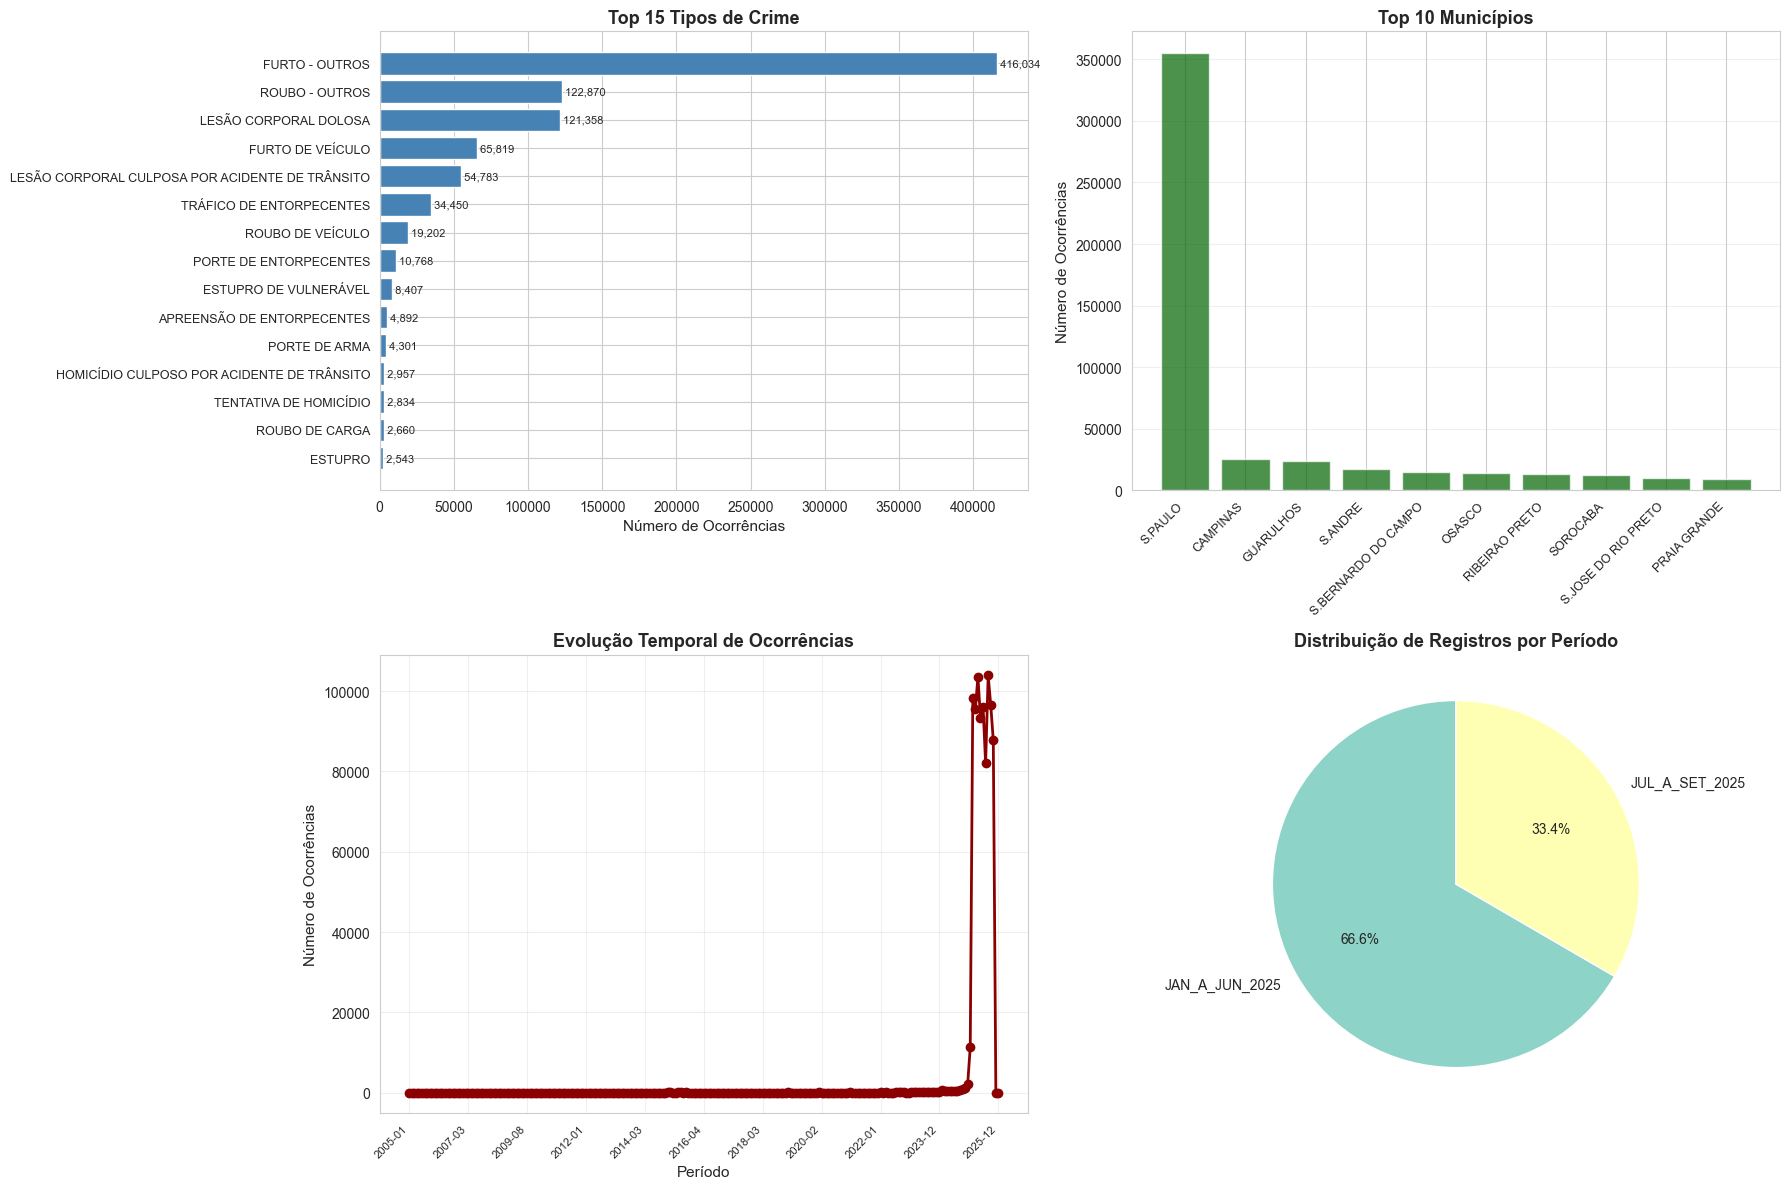

Visualizações criadas com sucesso!


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)

# Criar visualizações
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Gráfico 1: Top 15 Tipos de Crime
if 'NATUREZA_APURADA' in df_consolidated.columns:
    crime_counts = df_consolidated['NATUREZA_APURADA'].value_counts().head(15)
    axes[0, 0].barh(range(len(crime_counts)), crime_counts.values, color='steelblue')
    axes[0, 0].set_yticks(range(len(crime_counts)))
    axes[0, 0].set_yticklabels(crime_counts.index, fontsize=9)
    axes[0, 0].set_xlabel('Número de Ocorrências', fontsize=11)
    axes[0, 0].set_title('Top 15 Tipos de Crime', fontsize=13, fontweight='bold')
    axes[0, 0].invert_yaxis()
    for i, v in enumerate(crime_counts.values):
        axes[0, 0].text(v, i, f' {v:,}', va='center', fontsize=8)

# Gráfico 2: Top 10 Municípios
if 'NOME_MUNICIPIO' in df_consolidated.columns:
    mun_counts = df_consolidated['NOME_MUNICIPIO'].value_counts().head(10)
    axes[0, 1].bar(range(len(mun_counts)), mun_counts.values, color='darkgreen', alpha=0.7)
    axes[0, 1].set_xticks(range(len(mun_counts)))
    axes[0, 1].set_xticklabels(mun_counts.index, rotation=45, ha='right', fontsize=9)
    axes[0, 1].set_ylabel('Número de Ocorrências', fontsize=11)
    axes[0, 1].set_title('Top 10 Municípios', fontsize=13, fontweight='bold')
    axes[0, 1].grid(axis='y', alpha=0.3)

# Gráfico 3: Evolução Temporal (se houver data)
if 'DATA_OCORRENCIA_BO' in df_consolidated.columns:
    df_consolidated['ano_mes'] = df_consolidated['DATA_OCORRENCIA_BO'].dt.to_period('M')
    temporal = df_consolidated['ano_mes'].value_counts().sort_index()
    axes[1, 0].plot(range(len(temporal)), temporal.values, marker='o', linewidth=2, 
                    markersize=6, color='darkred')
    axes[1, 0].set_xlabel('Período', fontsize=11)
    axes[1, 0].set_ylabel('Número de Ocorrências', fontsize=11)
    axes[1, 0].set_title('Evolução Temporal de Ocorrências', fontsize=13, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    # Mostrar apenas alguns labels no eixo x
    step = max(1, len(temporal) // 10)
    axes[1, 0].set_xticks(range(0, len(temporal), step))
    axes[1, 0].set_xticklabels([str(temporal.index[i]) for i in range(0, len(temporal), step)], 
                                rotation=45, ha='right', fontsize=8)

# Gráfico 4: Distribuição por Aba de Origem
if 'aba_origem' in df_consolidated.columns:
    aba_counts = df_consolidated['aba_origem'].value_counts()
    colors = plt.cm.Set3(range(len(aba_counts)))
    axes[1, 1].pie(aba_counts.values, labels=aba_counts.index, autopct='%1.1f%%',
                   startangle=90, colors=colors)
    axes[1, 1].set_title('Distribuição de Registros por Período', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print("Visualizações criadas com sucesso!")

## 9. Salvar Metadados da Extração

Os metadados são informações sobre o processo de extração que permitem rastreabilidade e reprodutibilidade. Nesta etapa, salvamos um arquivo JSON contendo:

- Timestamp da extração
- Fonte dos dados originais
- Estatísticas do processo (tempo, registros, abas processadas)
- Métricas de qualidade (valores nulos, duplicatas, completude)
- Distribuições básicas (municípios, crimes, períodos)

Estes metadados são essenciais para documentação do projeto e auditoria do pipeline ETL, permitindo identificar mudanças nos dados fonte ao longo do tempo.

In [24]:
import json

# Criar metadados da extração
print()
print("SALVANDO METADADOS DA EXTRAÇÃO")
print()

metadata = {
    'data_extracao': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'fonte': 'SPDadosCriminais_2025.xlsx',
    'arquivo': str(EXCEL_FILE),
    'abas_extraidas': data_sheets,
    'estatisticas_extracao': extraction_stats,
    'dados_consolidados': {
        'total_registros': int(len(df_consolidated)),
        'total_colunas': int(len(df_consolidated.columns)),
        'colunas': list(df_consolidated.columns),
        'memoria_mb': float(df_consolidated.memory_usage(deep=True).sum() / 1024**2)
    },
    'qualidade': {
        'valores_nulos_por_coluna': df_consolidated.isnull().sum().to_dict(),
        'duplicatas': int(df_consolidated.duplicated().sum()),
        'registros_com_coordenadas': int(df_consolidated[['LATITUDE', 'LONGITUDE']].notna().all(axis=1).sum()) if 'LATITUDE' in df_consolidated.columns else 0
    },
    'periodo_temporal': {
        'data_minima': str(df_consolidated['DATA_OCORRENCIA_BO'].min()) if 'DATA_OCORRENCIA_BO' in df_consolidated.columns else None,
        'data_maxima': str(df_consolidated['DATA_OCORRENCIA_BO'].max()) if 'DATA_OCORRENCIA_BO' in df_consolidated.columns else None
    },
    'distribuicoes': {
        'municipios_unicos': int(df_consolidated['NOME_MUNICIPIO'].nunique()) if 'NOME_MUNICIPIO' in df_consolidated.columns else 0,
        'tipos_crime_unicos': int(df_consolidated['NATUREZA_APURADA'].nunique()) if 'NATUREZA_APURADA' in df_consolidated.columns else 0,
        'top_10_municipios': df_consolidated['NOME_MUNICIPIO'].value_counts().head(10).to_dict() if 'NOME_MUNICIPIO' in df_consolidated.columns else {},
        'top_10_crimes': df_consolidated['NATUREZA_APURADA'].value_counts().head(10).to_dict() if 'NATUREZA_APURADA' in df_consolidated.columns else {}
    }
}

# Salvar metadados
metadata_path = DATA_INTERIM_DIR / 'metadata_extracao.json'
DATA_INTERIM_DIR.mkdir(parents=True, exist_ok=True)

with open(metadata_path, 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False, default=str)

print(f"\nMetadados salvos em: {metadata_path}")
print(f"\nResumo da Extração:")
print(f"   • Total de registros: {len(df_consolidated):,}")
print(f"   • Total de colunas: {len(df_consolidated.columns)}")
print(f"   • Abas processadas: {len(data_sheets)}")
print(f"   • Memória: {df_consolidated.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"   • Duplicatas encontradas: {df_consolidated.duplicated().sum():,}")

print(f"\n{'='*80}")


SALVANDO METADADOS DA EXTRAÇÃO


Metadados salvos em: C:\Users\jodes\OneDrive\Documentos\Projetos-GitHub\public-security-data\data\interim\metadata_extracao.json

Resumo da Extração:
   • Total de registros: 878,793
   • Total de colunas: 30
   • Abas processadas: 2

Metadados salvos em: C:\Users\jodes\OneDrive\Documentos\Projetos-GitHub\public-security-data\data\interim\metadata_extracao.json

Resumo da Extração:
   • Total de registros: 878,793
   • Total de colunas: 30
   • Abas processadas: 2
   • Memória: 1483.35 MB
   • Memória: 1483.35 MB
   • Duplicatas encontradas: 13

   • Duplicatas encontradas: 13



## 10. Salvar Dados Consolidados

Nesta etapa final, salvamos o dataset consolidado em formato Parquet no diretório `data/interim/`. O formato Parquet oferece várias vantagens:

- Compressão eficiente, reduzindo espaço em disco
- Leitura e escrita mais rápidas que CSV
- Preservação de tipos de dados
- Suporte a estruturas complexas

Os dados salvos estarão prontos para serem consumidos pelo notebook de transformação (etapa 2 do pipeline ETL). O arquivo `dados_brutos_consolidados.parquet` contém todos os registros extraídos, com coluna de identificação da aba de origem para rastreabilidade.

In [25]:
# Salvar dados consolidados em formato Parquet
print()
print("SALVANDO DADOS CONSOLIDADOS")
print()

# Caminho para salvar
output_path = DATA_INTERIM_DIR / 'dados_brutos_consolidados.parquet'

print(f"\nSalvando dados em formato Parquet...")

# Converter colunas object para string para evitar erros de tipo misto
df_to_save = df_consolidated.copy()
for col in df_to_save.select_dtypes(include=['object']).columns:
    df_to_save[col] = df_to_save[col].astype(str)

df_to_save.to_parquet(output_path, compression='snappy', index=False)

# Verificar arquivo salvo
if output_path.exists():
    size_mb = output_path.stat().st_size / (1024**2)
    print(f"Dados salvos com sucesso!")
    print(f"Arquivo: {output_path.name}")
    print(f"Tamanho: {size_mb:.2f} MB")
    print(f"Localização: {output_path}")
else:
    print(f"Erro ao salvar dados")

print(f"\n{'='*80}")


SALVANDO DADOS CONSOLIDADOS


Salvando dados em formato Parquet...
Dados salvos com sucesso!
Arquivo: dados_brutos_consolidados.parquet
Tamanho: 33.57 MB
Localização: C:\Users\jodes\OneDrive\Documentos\Projetos-GitHub\public-security-data\data\interim\dados_brutos_consolidados.parquet

Dados salvos com sucesso!
Arquivo: dados_brutos_consolidados.parquet
Tamanho: 33.57 MB
Localização: C:\Users\jodes\OneDrive\Documentos\Projetos-GitHub\public-security-data\data\interim\dados_brutos_consolidados.parquet



## 11. Resumo e Próximos Passos

### Resumo da Extração

Neste notebook, realizamos:
1. Configuração do ambiente e importação de bibliotecas
2. Localização e validação do arquivo Excel
3. Análise da estrutura do arquivo (abas, colunas)
4. Extração completa dos dados de todas as abas
5. Consolidação dos dados em um único DataFrame
6. Análise preliminar da estrutura e conteúdo
7. Análise de dados chave (municípios, crimes, período temporal)
8. Criação de visualizações iniciais
9. Salvamento de metadados da extração

### Estatísticas Principais

- **Total de Registros**: {len(df_consolidated):,}
- **Total de Colunas**: {len(df_consolidated.columns)}
- **Abas Processadas**: {len(data_sheets)}
- **Municípios Únicos**: {df_consolidated['NOME_MUNICIPIO'].nunique() if 'NOME_MUNICIPIO' in df_consolidated.columns else 'N/A'}
- **Tipos de Crime**: {df_consolidated['NATUREZA_APURADA'].nunique() if 'NATUREZA_APURADA' in df_consolidated.columns else 'N/A'}
- **Registros com Coordenadas**: {df_consolidated[['LATITUDE', 'LONGITUDE']].notna().all(axis=1).sum():,} ({df_consolidated[['LATITUDE', 'LONGITUDE']].notna().all(axis=1).sum()/len(df_consolidated)*100:.1f}%) {' se LATITUDE in df_consolidated.columns else N/A'}

### Próximos Passos

1. **Transformação**: Seguir para o notebook `2_transformacao.ipynb` para:
   - Limpar e normalizar nomes de colunas
   - Remover duplicatas
   - Processar datas e criar features temporais
   - Validar e processar coordenadas geográficas
   - Categorizar tipos de crime
   - Tratar valores ausentes

2. **Carga**: Usar o notebook `3_carga.ipynb` para:
   - Salvar dados processados em formatos otimizados (CSV, Parquet)
   - Criar versões agregadas dos dados
   - Gerar subset geográfico para mapas
   - Criar metadados finais

### Dados Extraídos

Os dados brutos consolidados estão disponíveis em:
- `data/interim/dados_brutos_consolidados.parquet` 
- `data/interim/metadata_extracao.json` 

In [26]:
# Resumo final
print()
print("EXTRAÇÃO CONCLUÍDA COM SUCESSO!")
print()

print(f"\nEstatísticas Finais:")
print(f"   • Registros extraídos: {len(df_consolidated):,}")
print(f"   • Colunas: {len(df_consolidated.columns)}")
print(f"   • Memória utilizada: {df_consolidated.memory_usage(deep=True).sum() / 1024**2:.2f} MB") # tá certo isso?

print(f"\nArquivos gerados:")
print(f"   • {DATA_INTERIM_DIR / 'dados_brutos_consolidados.parquet'}")
print(f"   • {DATA_INTERIM_DIR / 'metadata_extracao.json'}")


EXTRAÇÃO CONCLUÍDA COM SUCESSO!


Estatísticas Finais:
   • Registros extraídos: 878,793
   • Colunas: 30
   • Memória utilizada: 1507.64 MB

Arquivos gerados:
   • C:\Users\jodes\OneDrive\Documentos\Projetos-GitHub\public-security-data\data\interim\dados_brutos_consolidados.parquet
   • C:\Users\jodes\OneDrive\Documentos\Projetos-GitHub\public-security-data\data\interim\metadata_extracao.json
   • Memória utilizada: 1507.64 MB

Arquivos gerados:
   • C:\Users\jodes\OneDrive\Documentos\Projetos-GitHub\public-security-data\data\interim\dados_brutos_consolidados.parquet
   • C:\Users\jodes\OneDrive\Documentos\Projetos-GitHub\public-security-data\data\interim\metadata_extracao.json
